# Сбор данных
**Сбор данных с Авито**


In [1]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-
import requests
import string
from bs4 import CData
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from geopy.geocoders import GoogleV3
geolocator = Nominatim()
res = []
pages_num = 4

for i in range(1, pages_num):
    url = "https://www.avito.ru/moskva/kvartiry/sdam/na_dlitelnyy_srok?p=" + str(i) +"&metro=7-25-30-110&f=550_5702-5703-5704"

    session = requests.Session()
    html_code = session.get(url)
    soup = BeautifulSoup(html_code.text, 'html.parser')

    for elem in soup.find_all("div", {"class": "item_table"}):
        res.append([])
        for d in elem.find_all("div", {"class": "description"}):
            s = d.find("div", {"class": "about"}).text.strip().split('\n')[0].strip()
            s = s.replace(" руб. в месяц", "")
            s = s.replace(" ", "")
            if (int(s) < 10000):
                res.pop()
                continue
            res[-1].append(s)
            v = d.find("div", {"class": "item_table-header"}).h3.text.strip().split(", ")
            v[0] = str(v[0][0])
            v[1] = str(v[1].replace(" м²", ""))
            v[2] = str(v[2].replace(" эт.", ""))
            res[-1] += v
            s = d.find("i", {"class": "i-metro"}).next_element.string.strip()
            res[-1].append(s)
            s = d.find("i", {"class": "i-metro"}).next_element.next_element.string.strip()
            if (s.find("км")):
                s = s.replace(" км", "00")
                if (not(s.find("."))):
                    s += "0"
                else:
                    s = s.replace(".", "")
            if (s.find(" м")):
                s = s.replace(" м", "")
            if (len(s) == 0 or not s.isdigit):
                res.pop()
                continue
            res[-1].append(s)
            s = d.find("i", {"class": "i-metro i-metro-msk-2"}).next_element.next_element.next_element.next_element
            s = s[2:]
            s = s.replace("Москва, ", "")
            s = s.replace(chr(160), " ")
            s = s.replace(chr(8722), "-")
            s += ", г. Москва"
            if (s == "улица Степана Супруна, 3-5 , г. Москва"):
                res.pop()
                continue
            if (s == "ул Алабяна , г. Москва"):
                res.pop()
                continue
            if (s == "Беговая аллея д. 3 , г. Москва"):
                s = "Беговая аллея, д. 3 , г. Москва"
            res[-1].append(s)
#for i in range(len(res)):
#    location = geolocator.geocode(res[i][-1])
#    print(location.address)
#    print(location.latitude, location.longitude)
f = open('avito.txt', 'w')
for i in range (0, len(res)):
    for j in range (0, len(res[i])):
        f.write(str(res[i][j]) + "; ")
    f.write('\n')
f.close()


**Сбор данных с Домофонд**

In [2]:
import requests
from bs4 import CData
from bs4 import BeautifulSoup

pages_num = 22
res = []
for i in range(1, pages_num):
    url = "https://www.domofond.ru/arenda-nedvizhimosti/search?MetroIds=21%2C44%2C124%2C39&PropertyTypeDescription=kvartiry&RentalRate=Month&Rooms=One%2CTwo&Page="+str(i)
    session = requests.Session()
    html_code = session.get(url)
    soup = BeautifulSoup(html_code.text, 'html.parser')
    for elem in soup.find_all("div", {"class": "media-body e-content clearfix"}):
        res.append([])
        s = elem.a.h2.text
        for i in range (0, len(s)):
            if (ord(s[i]) == 160):
                s = s.replace(s[i], " ")
        s = s.replace(" ", "")
        s = s.replace("РУБ.", "")
        res[-1].append(s)
        for d in elem.find_all("span", {"class": "e-tile-type m-max-width text-overflow"}):
            v = d.text.strip().split(", ")
            v[0] = str(v[0][0])
            v[1] = str(v[1].replace(" м²", ""))
            v[2] = str(v[2].replace(" эт.", ""))
            res[-1] += (v)
        mtr = elem.find("div", {"class": "e-metro-distance"})
        mtr = mtr.strong.text.split(" ")
        res[-1].append(mtr[0][1:])
        if (mtr[2] == "м"):
            res[-1].append(mtr[1])
        else:
            mtr[1] = mtr[1].replace(",", ".")
            mtr[1] = int(float(mtr[1]) * 1000)
            res[-1].append(mtr[1])
        for ad in elem.find_all("span", {"class": "e-tile-address"}):
            res[-1].append(ad.span.text)
f = open('domofond.txt', 'w')
for i in range (0, len(res)):
    for j in range (0, len(res[i])):
        f.write(str(res[i][j]) + "; ")
    f.write('\n')
f.close()

**Выгрузка данных в таблицу html**

In [3]:
out = open('index.html', 'w')
out.write("<!DOCTYPE html>\n")
out.write("<html>\n")
out.write("<body>\n")
out.write("<h2> Съёмное жильё в Москве на севере Замоскворецкой линии <h2>\n")
out.write('<table style="width:100%">\n')
header = ["Цена", "Кол-во комнат", "Площадь", "Этаж", "Станция метро", "Расстояние до метро", "Адрес"]
out.write("<tr>\n")
for elem in header:
    out.write("<th>")
    out.write(elem)
    out.write("</th>\n")
out.write("</tr>\n")
for i in range(len(res)):
    out.write("<tr>\n")
    for j in range (len(res[i])):
        out.write("<th>")
        out.write(str(res[i][j]))
        out.write("</th>\n")
    out.write("</tr>\n")
out.close()

Для начала сравним арендную плату на разных станциях метро. Некорректно было бы сравнивать средние цены вообще (где-то двухкомнатных квартир больше, соответственно средняя цена будет выше), поэтому разделим все квартиры на два кластера.

97 39 25 68
171 69 40 79


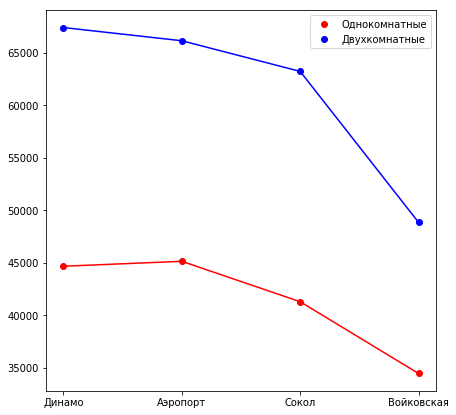

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
sd1 = 0
sd1sum = 0
sa1 = 0
sa1sum = 0
ss1 = 0
ss1sum = 0
sv1 = 0
sv1sum = 0
sd2 = 0
sd2sum = 0
sa2 = 0
sa2sum = 0
ss2 = 0
ss2sum = 0
sv2 = 0
sv2sum = 0
for i in range(len(res)):
    if (res[i][4] == "Динамо"):
        if (res[i][1] == '1'):
            sd1 += int(1)
            sd1sum += int(res[i][0])
        if (res[i][1] == '2'):
            sd2 += int(1)
            sd2sum += int(res[i][0])
    elif (res[i][4] == "Аэропорт"):
        if (res[i][1] == '1'):
            sa1 += int(1)
            sa1sum += int(res[i][0])
        if (res[i][1] == '2'):
            sa2 += int(1)
            sa2sum += int(res[i][0])
    elif (res[i][4] == "Сокол"):
        if (res[i][1] == '1'):
            ss1 += int(1)
            ss1sum += int(res[i][0])
        if (res[i][1] == '2'):
            ss2 += int(1)
            ss2sum += int(res[i][0])
    elif (res[i][4] == "Войковская"):
        if (res[i][1] == '1'):
            sv1 += int(1)
            sv1sum += int(res[i][0])
        if (res[i][1] == '2'):
            sv2 += int(1)
            sv2sum += int(res[i][0])
sd1mean = sd1sum/sd1
sa1mean = sa1sum/sa1
ss1mean = ss1sum/ss1
sv1mean = sv1sum/sv1
sd2mean = sd2sum/sd2
sa2mean = sa2sum/sa2
ss2mean = ss2sum/ss2
sv2mean = sv2sum/sv2
one = [sd1mean, sa1mean, ss1mean, sv1mean]
names = ['Динамо', 'Аэропорт', 'Сокол', 'Войковская']
two = [sd2mean, sa2mean, ss2mean, sv2mean]
print(sd1, sa1, ss1, sv1)
print(sd2, sa2, ss2, sv2)
plt.figure(figsize=(7,7))
x = [0,1,2,3]
plt.xticks(x, names)
p1 = plt.plot(x, one, 'bo', x, one, 'k', color='red')
p2 =plt.plot(x, two, 'bo', x, two, 'k', color='blue')
plt.legend((p1[0], p2[0]), ('Однокомнатные', 'Двухкомнатные'))
plt.show()

На графике можно увидеть, что однокомнатные резонно стоят дешевле, однако всего на несколько тысяч. Это обусловлено рамками бюджета (в проекте рассматриваются квартиры с арендной платой до 40000 рублей). На Динамо в рамках бюджета рассматриваются самые бюджетные и, честно, не очень комфортабельные и красивые квартиры. Аэропорт - самый дорогой из выбранных районов. Далее от центра количество предложений возрастает, из чего следует, что средняя цена более реалистична на большей выборке. 

Теперь рассмотрим зависимость цены от дальности непосредственно станций метро. Близость к метро важна на всех станциях, кроме "Аэропорт", на которой идеальное расстояние от метро - около километра. 

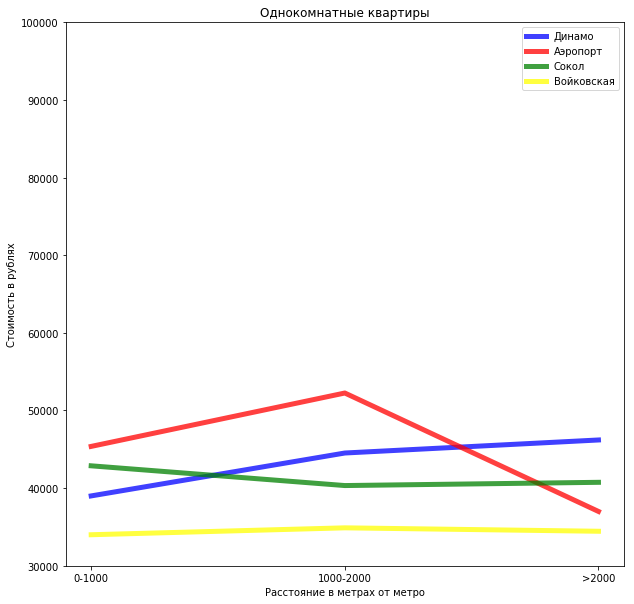

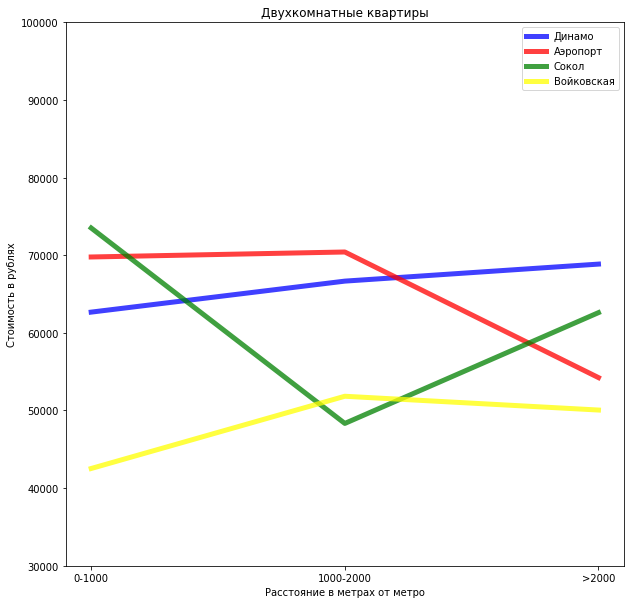

In [5]:
dnum = [0,0,0,0,0,0]
dsum = [0,0,0,0,0,0]
anum = dnum.copy()
asum = dsum.copy()
snum = dnum.copy()
ssum = dsum.copy()
vnum = dnum.copy()
vsum = dsum.copy()
for i in range(len(res)):
    if (res[i][4] == "Динамо"):
        if (res[i][1] == '1'):
            if (int(res[i][5]) <= 1000):
                dnum[0] += int(1)
                dsum[0] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                dnum[1] += int(1)
                dsum[1] += int(res[i][0])
            else:
                dnum[2] += int(1)
                dsum[2] += int(res[i][0])
        if (res[i][1] == '2'):
            if (int(res[i][5]) <= 1000):
                dnum[3] += int(1)
                dsum[3] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                dnum[4] += int(1)
                dsum[4] += int(res[i][0])
            else:
                dnum[5] += int(1)
                dsum[5] += int(res[i][0])
    if (res[i][4] == "Аэропорт"):
        if (res[i][1] == '1'):
            if (int(res[i][5]) <= 1000):
                anum[0] += int(1)
                asum[0] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                anum[1] += int(1)
                asum[1] += int(res[i][0])
            else:
                anum[2] += int(1)
                asum[2] += int(res[i][0])
        if (res[i][1] == '2'):
            if (int(res[i][5]) <= 1000):
                anum[3] += int(1)
                asum[3] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                anum[4] += int(1)
                asum[4] += int(res[i][0])
            else:
                anum[5] += int(1)
                asum[5] += int(res[i][0])
    if (res[i][4] == "Сокол"):
        if (res[i][1] == '1'):
            if (int(res[i][5]) <= 1000):
                snum[0] += int(1)
                ssum[0] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                snum[1] += int(1)
                ssum[1] += int(res[i][0])
            else:
                snum[2] += int(1)
                ssum[2] += int(res[i][0])
        if (res[i][1] == '2'):
            if (int(res[i][5]) <= 1000):
                snum[3] += int(1)
                ssum[3] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                snum[4] += int(1)
                ssum[4] += int(res[i][0])
            else:
                snum[5] += int(1)
                ssum[5] += int(res[i][0])
    if (res[i][4] == "Войковская"):
        if (res[i][1] == '1'):
            if (int(res[i][5]) <= 1000):
                vnum[0] += int(1)
                vsum[0] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                vnum[1] += int(1)
                vsum[1] += int(res[i][0])
            else:
                vnum[2] += int(1)
                vsum[2] += int(res[i][0])
        if (res[i][1] == '2'):
            if (int(res[i][5]) <= 1000):
                vnum[3] += int(1)
                vsum[3] += int(res[i][0])
            elif (int(res[i][5]) <= 2000):
                vnum[4] += int(1)
                vsum[4] += int(res[i][0])
            else:
                vnum[5] += int(1)
                vsum[5] += int(res[i][0])
dinamomean = [dsum[0]/dnum[0], dsum[1]/dnum[1], dsum[2]/dnum[2], dsum[3]/dnum[3], dsum[4]/dnum[4], dsum[5]/dnum[5]]
aeroportmean = [asum[0]/anum[0], asum[1]/anum[1], asum[2]/anum[2], asum[3]/anum[3], asum[4]/anum[4], asum[5]/anum[5]]
sokolmean = [ssum[0]/snum[0], ssum[1]/snum[1], ssum[2]/snum[2], ssum[3]/snum[3], ssum[4]/snum[4], ssum[5]/snum[5]]
voikovskayamean = [vsum[0]/vnum[0], vsum[1]/vnum[1], vsum[2]/vnum[2], vsum[3]/vnum[3], vsum[4]/vnum[4], vsum[5]/vnum[5]]
plt.figure(figsize=(10,10))
x = [0,1,2]
dist = ['0-1000','1000-2000', '>2000']
plt.xticks(x, dist)
ax = plt.gca()
ax.set_ylim([30000,100000])
p1 = plt.plot(x, dinamomean[:3], color='blue', axes=ax, linewidth=5.0, alpha=0.75)
p2 = plt.plot(x, aeroportmean[:3], color='red',axes=ax, linewidth=5.0, alpha=0.75)
p3 = plt.plot(x,sokolmean[:3], color='green',axes=ax, linewidth=5.0, alpha=0.75)
p4 = plt.plot(x, voikovskayamean[:3], color='yellow',axes=ax, linewidth=5.0, alpha=0.75)
plt.title('Однокомнатные квартиры')
plt.xlabel('Расстояние в метрах от метро')
plt.ylabel('Стоимость в рублях')
plt.legend((p1[0],p2[0],p3[0],p4[0]), ('Динамо', 'Аэропорт', 'Сокол', 'Войковская'))
plt.show()

plt.figure(figsize=(10,10))
x = [0,1,2]
dist = ['0-1000','1000-2000', '>2000']
plt.xticks(x, dist)
ax = plt.gca()
ax.set_ylim([30000,100000])
p1 = plt.plot(x, dinamomean[3:], color='blue', axes=ax, linewidth=5.0, alpha=0.75)
p2 = plt.plot(x, aeroportmean[3:], color='red', axes=ax, linewidth=5.0, alpha=0.75)
p3 = plt.plot(x,sokolmean[3:], color='green',axes=ax, linewidth=5.0, alpha=0.75)
p4 = plt.plot(x, voikovskayamean[3:], color='yellow',axes=ax, linewidth=5.0, alpha=0.75)
plt.title('Двухкомнатные квартиры')
plt.xlabel('Расстояние в метрах от метро')
plt.ylabel('Стоимость в рублях')
plt.legend((p1[0],p2[0],p3[0],p4[0]), ('Динамо', 'Аэропорт', 'Сокол', 'Войковская'))
plt.show()


[90, 123, 49, 6]
[32, 52, 15, 9]
[18, 34, 6, 7]
[64, 70, 9, 4]


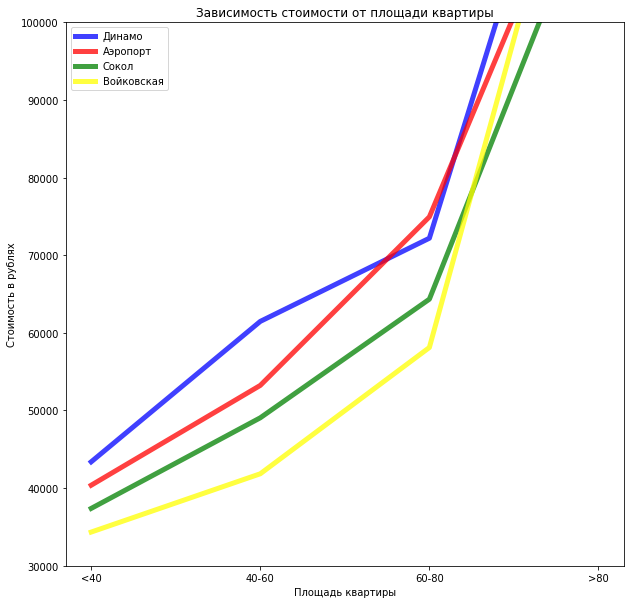

In [6]:
dnum = [0,0,0,0]
dsum = [0,0,0,0]
anum = dnum.copy()
asum = dsum.copy()
snum = dnum.copy()
ssum = dsum.copy()
vnum = dnum.copy()
vsum = dsum.copy()
for i in range(len(res)):
    if (res[i][4] == "Динамо"):
        if (float(res[i][2]) <= float(40)):
            dnum[0] += int(1)
            dsum[0] += int(res[i][0])
        elif (float(res[i][2]) <= float(60)):
            dnum[1] += int(1)
            dsum[1] += int(res[i][0])
        elif (float(res[i][2]) <= float(80)):
            dnum[2] += int(1)
            dsum[2] += int(res[i][0])
        elif (float(res[i][2]) <= float(200)):
            dnum[3] += int(1)
            dsum[3] += int(res[i][0])           
    if (res[i][4] == "Аэропорт"):
        if (float(res[i][2]) <= float(40)):
            anum[0] += int(1)
            asum[0] += int(res[i][0])
        elif (float(res[i][2]) <= float(60)):
            anum[1] += int(1)
            asum[1] += int(res[i][0])
        elif (float(res[i][2]) <= float(80)):
            anum[2] += int(1)
            asum[2] += int(res[i][0])
        elif (float(res[i][2]) <= float(200)):
            anum[3] += int(1)
            asum[3] += int(res[i][0])  
    if (res[i][4] == "Сокол"):
        if (float(res[i][2]) <= float(40)):
            snum[0] += int(1)
            ssum[0] += int(res[i][0])
        elif (float(res[i][2]) <= float(60)):
            snum[1] += int(1)
            ssum[1] += int(res[i][0])
        elif (float(res[i][2]) <= float(80)):
            snum[2] += int(1)
            ssum[2] += int(res[i][0])
        elif (float(res[i][2]) <= float(200)):
            snum[3] += int(1)
            ssum[3] += int(res[i][0])     
    if (res[i][4] == "Войковская"):
        if (float(res[i][2]) <= float(40)):
            vnum[0] += int(1)
            vsum[0] += int(res[i][0])
        elif (float(res[i][2]) <= float(60)):
            vnum[1] += int(1)
            vsum[1] += int(res[i][0])
        elif (float(res[i][2]) <= float(80)):
            vnum[2] += int(1)
            vsum[2] += int(res[i][0])
        elif (float(res[i][2]) <= float(200)):
            vnum[3] += int(1)
            vsum[3] += int(res[i][0]) 
dinamomean = [dsum[0]/dnum[0], dsum[1]/dnum[1], dsum[2]/dnum[2], dsum[3]/dnum[3]]
aeroportmean = [asum[0]/anum[0], asum[1]/anum[1], asum[2]/anum[2], asum[3]/anum[3]]
sokolmean = [ssum[0]/snum[0], ssum[1]/snum[1], ssum[2]/snum[2], ssum[3]/snum[3]]
voikovskayamean = [vsum[0]/vnum[0], vsum[1]/vnum[1], vsum[2]/vnum[2], vsum[3]/vnum[3]]
print(dnum)
print(anum)
print(snum)
print(vnum)
plt.figure(figsize=(10,10))
x = [0,1,2,3]
dist = ['<40', '40-60', '60-80', '>80']
plt.xticks(x, dist)
ax = plt.gca()
ax.set_ylim([30000,100000])
p1 = plt.plot(x, dinamomean, color='blue', axes=ax, linewidth=5.0, alpha=0.75)
p2 = plt.plot(x, aeroportmean, color='red',axes=ax, linewidth=5.0, alpha=0.75)
p3 = plt.plot(x,sokolmean, color='green',axes=ax, linewidth=5.0, alpha=0.75)
p4 = plt.plot(x, voikovskayamean, color='yellow',axes=ax, linewidth=5.0, alpha=0.75)
plt.title('Зависимость стоимости от площади квартиры')
plt.xlabel('Площадь квартиры')
plt.ylabel('Стоимость в рублях')
plt.legend((p1[0],p2[0],p3[0],p4[0]), ('Динамо', 'Аэропорт', 'Сокол', 'Войковская'))
plt.show()


Я намеренно отсеяла помещения площадью более 200 квадратных метров, поскольку зачастую это офисные здания. Относительно площади можно с уверенностью сказать, что стоимость зависит от площади прямопропорционально. При маленьких площадях соблюдается зависимость и от станции метро, однако чем дальше от центра, тем непредсказуемее. На основе всех графиков можно предположить, что на среднем расстоянии от метро есть элитные районы, стоимость жилья в которых резко растёт вне зависимости от близости к метро и площади квартиры.